# Numerical Minimization

In [1]:
using LinearAlgebra
using ForwardDiff
using PyPlot

The minimization problem seeks to find the point $x^*$ such that $f(x^*)$ is at its minimum value. In practice this requires using the derivatives of $f(x)$ to determine where this point is. We set the first derivative equal to zero $f(x^*) = 0$ and solve for $x^*$. If the second derivative is greater than zero we're minimizing, and otherwise we are maximizing. 

## Constrained Minimization
We can also minimize functions subject to constraints in the form: 
$$
\begin{align}
\min_x \qquad &f(x) \\
\mathrm{s.t} \qquad &c(x) = 0
\end{align}$$
which reads as "minimize $f(x)$ subject to the constraint $c(x) = 0$". We can use Newton's method to minimize a function. As an example, let's solve the following problem:

$$ 
\begin{align}
\min_x \qquad &\frac{1}{2} (x - o)^T Q (x - o) \\
\mathrm{s.t} \qquad &x_1^2 + 2x_1 - x_2 = 0
\end{align}$$
where $x,o \in \mathbb{R}^2$, and we have a constraint function we need to minimize the function with respect to. The constraint can be written as $x_2 = x_1^2 + 2x_1$, which is simply the formula for a parabola. 

We require that any non-zero component of $\nabla f$ must be normal to the constraint manifold such that: 
$$
\nabla f + \lambda \nabla c = 0
$$
This condition is how we describe components of $f(x)$ that lie along the constraight $c(x)$. 

The way we solve this is by using the Lagrange multiplier method. We define the _Lagrangian_: 
$$
\begin{align}
L(x, \lambda) &= f(x) + \lambda c(x), \\
\nabla_x L(x, \lambda) &= \nabla f + \left(\frac{\partial c}{\partial x}\right)^T \lambda = 0,  \\
\nabla_{\lambda} L(x, \lambda) &= c(x)
\end{align}
$$



We can then solve this jointly in $x$ and $\lambda$ with Newton's method: 
$$
\begin{align}
    \nabla_x L(x + \Delta x, \lambda + \Delta \lambda) &\approx \nabla_x L(x, \lambda) + \frac{\partial^2 L}{\partial x^2} \Delta x + \frac{\partial^2 L}{\partial x \partial \lambda} \Delta \lambda, & \frac{\partial^2 L}{\partial x \partial \lambda} = \frac{\partial c}{\partial x},\\
    \nabla_{\lambda} L(x + \Delta x, \lambda) &\approx c(x) + \frac{\partial c}{\partial x} \Delta x, \\
    \begin{bmatrix}
    \frac{\partial^2 L}{\partial x^2} & \left(\frac{\partial c}{\partial x}\right)^T \\
    \frac{\partial c}{\partial x} & 0
    \end{bmatrix}
    \begin{bmatrix}
    \Delta x \\
    \Delta \lambda
    \end{bmatrix}
    &=
    \begin{bmatrix}
    \nabla_x L(x, \lambda) \\
    -c(x)
    \end{bmatrix}
\end{align}
$$

This is called a KKT system. We can apply something called the Gauss-Newton method, which computes the second derivative of $L$ with respect to $x$ as: 
$$
\begin{align}
\frac{\partial^2 L}{\partial x^2} &= \nabla^2 f + \frac{\partial}{\partial x} \left[ \left(\frac{\partial c}{\partial x}\right)^T \lambda \right] \\
\frac{\partial^2 L}{\partial x^2} &\approx \nabla^2 f
\end{align}
$$
This is because the second term ("constraint curvature") in the first equation is expensive to compute. Performing Gauss-Newton is equivalent to linearizing first which effectively zeros out the curvature, then doing Newton. 

In [2]:
# quadratic weights
Q = Diagonal([0.5; 1])
offset = [1; 0]
# define the function and first two derivatives
f(x) = 0.5*(x - offset)' * Q * (x - offset)
∇f(x)= Q*(x - offset)
∇2f(x)= Q

∇2f (generic function with 1 method)

In [3]:
# the constraint functions
c(x) = x[1]^2 + 2x[1] - x[2]
∇c(x) = [2x[1] + 2   -1]

∇c (generic function with 1 method)

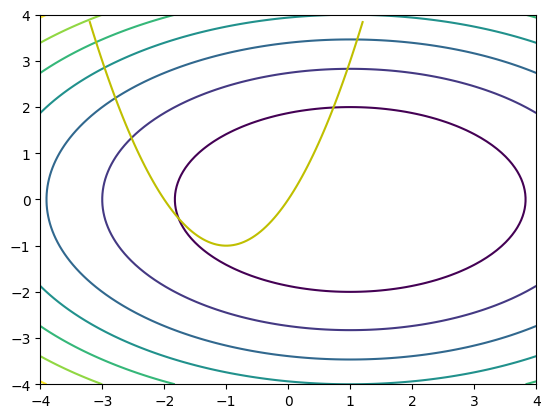

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe1bfa85f60>

In [4]:
function plot_landscape()
    n, up, low = 100, -4, 4
    # calculate outer product to make a meshgrid
    x = ones(n) * LinRange(low, up, n)'
    y = LinRange(low, up, n) * ones(n)'
    # use array comprehension to populate z array
    z = [f([x[i, j]; y[i, j]]) for i = 1:n, j=1:n]
    contour(x, y, z)
    
    # plot constraint
    xc = LinRange(-3.2, 1.2, n)
    plot(xc,xc.^2+2.0.*xc,"y")

end

plot_landscape()
    

First we can see how normal Newton's method performs with the constraint curvature term. 

In [5]:
function newton_step(x0,λ0)
    # compute the hessian of objective, with the constraint curvature term
    H = ∇2f(x0) + ForwardDiff.jacobian(x -> ∇c(x)'*λ0, x0)
    C = ∇c(x0)
    # solve the linear KKT system Ax = b
    Δz = [H C'; C 0]\[-∇f(x0)-C'*λ0; -c(x0)]
    # obtain the update rules for Δx and Δλ
    Δx = Δz[1:2]
    Δλ = Δz[3]
    return x0+Δx, λ0+Δλ
end

newton_step (generic function with 1 method)

Initial guess for Newton's method matters a lot. If we were to guess $x=[-3, 1]^T$ then the method doesn't converge at all.  

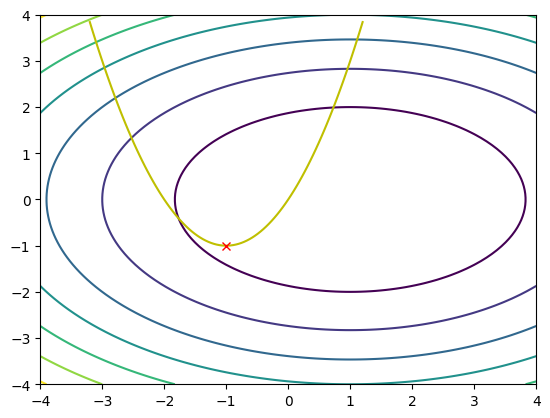

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe22e9e20f0>

In [6]:

xguess = [-1; -1]
λguess = [0.0]
plot_landscape()
plot(xguess[1], xguess[2], "rx")

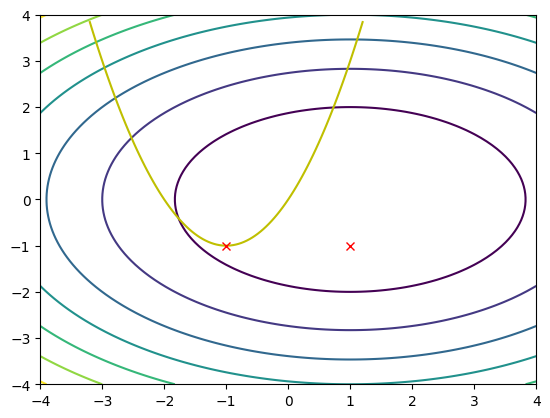

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe22e956048>

In [7]:
xnew, λnew = newton_step(xguess[:,end],λguess[end])
xguess = [xguess xnew]
λguess = [λguess λnew]
plot_landscape()
plot(xguess[1,:], xguess[2,:], "rx")

Now we can see how the Gauss-Newton method compares. 

In [8]:
function gauss_newton_step(x0, λ0)
    # compute the hessian of objective, with the constraint curvature term
    H = ∇2f(x0)
    C = ∇c(x0)
    # solve the linear KKT system Ax = b
    Δz = [H C'; C 0]\[-∇f(x0)-C'*λ0; -c(x0)]
    # obtain the update rules for Δx and Δλ
    Δx = Δz[1:2]
    Δλ = Δz[3]
    return x0+Δx, λ0+Δλ
end

gauss_newton_step (generic function with 1 method)

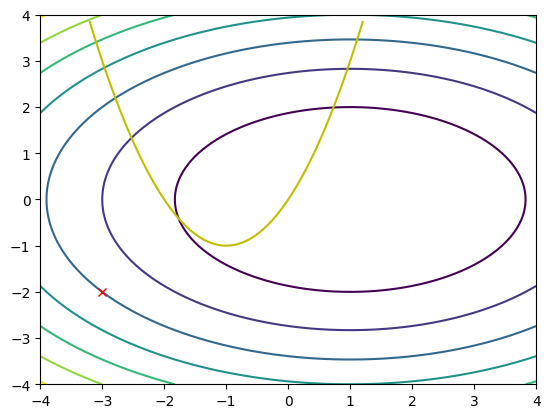

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe1bf7a8e10>

In [9]:

xguess = [-3; -2]
λguess = [0.0]
plot_landscape()
plot(xguess[1], xguess[2], "rx")

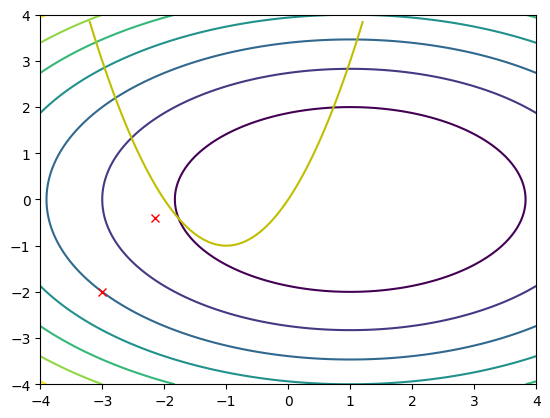

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe1bf7977f0>

In [10]:
xnew, λnew = gauss_newton_step(xguess[:,end],λguess[end])
xguess = [xguess xnew]
λguess = [λguess λnew]
plot_landscape()
plot(xguess[1,:], xguess[2,:], "rx")

Gauss Newton can actually handle a further initial guess than Newton's method. We get stuck with Newton's method when we try and use the constraint curvature because we're adding negative eigen values into the Hessian of the Lagrangian, which sort of added a local optima. We can use some regularization to fix this but it's better to use Gauss-Newton. 

## Inequality Constraints
We can also solve a minimization problem of the form: 

$$
\begin{align}
\min_x \qquad &f(x) \\
\mathrm{s.t} \qquad &c(x) \geq 0
\end{align}$$
This is much more difficult to do. So we can try and convert this into a problem that uses an equality constraint. 


We do this by changing the overall objective function to use a Lagrange multiplier and a quadratic _penalty term_, called the Augmented Lagrangian $L_{\rho}$. 
$$
\min_x \quad f(x) - \tilde{\lambda}^T c(x) + \frac{\rho}{2}[min(0, c(x))]^2
$$
When solving the augmented Lagrangian we only minimize over $x$, so we need to update the Lagrange multiplier before the next minimization iteration of $x$. 
$$
\frac{\partial f}{\partial x} - [\tilde{\lambda} - \rho c(x)]^T \frac{\partial c}{\partial x} \\
\tilde{\lambda} \gets \tilde{\lambda} - \rho c(x)
$$

We repeat this until a convergence is found, just like the Gauss Newton Method: 
1. Min $L_{\rho, \tilde{\lambda}}$
2. $\tilde{\lambda} \gets \tilde{\lambda} - min(0, \rho c(x)$)
3. $\rho \gets \alpha \rho$

## Quadratic Programs
We can put equality and inequality constraints together to create quadratic program. This takes the form:
$$
\begin{align}
\min_x \qquad &\frac{1}{2} x^T Q x, \qquad Q > 0, \quad \mathrm{\it convex} \\
\mathrm{s.t} \qquad &Ax \leq b \\
&Cx = d
\end{align}$$
These are all over the land of robotic optimal control. Can be solved really fast online. We now try to solve the following problem: 
$$ 
\begin{align}
\min_x \qquad &\frac{1}{2} (x - o)^T Q (x - o) \\
\mathrm{s.t} \qquad &[1.0, 1.0] x + 1.0 = 0
\end{align}
$$

In [11]:
# quadratic weights
Q = Diagonal([0.5; 1])
offset = [1; 0]
# define the function and first two derivatives
f(x) = 0.5*(x - offset)' * Q * (x - offset)
∇f(x)= Q*(x - offset)
∇2f(x)= Q

∇2f (generic function with 1 method)

In [12]:
A = [1.0 -1.0]
b = -1.0
# constraint is now linear 
c(x) = dot(A, x) - b
∂c(x) = A

∂c (generic function with 1 method)

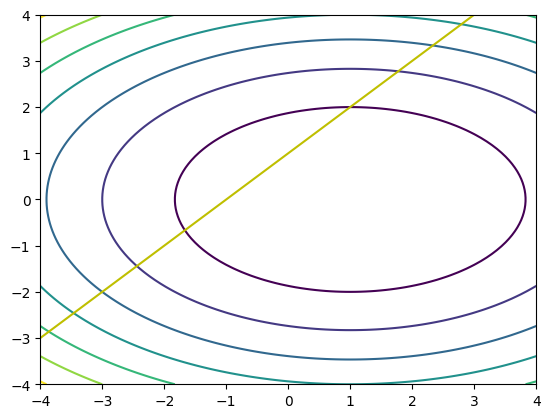

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe1bf1149e8>

In [13]:
function plot_landscape()
    n, up, low = 100, -4, 4
    # calculate outer product to make a meshgrid
    x = ones(n) * LinRange(low, up, n)'
    y = LinRange(low, up, n) * ones(n)'
    # use array comprehension to populate z array
    z = [f([x[i, j]; y[i, j]]) for i = 1:n, j=1:n]
    contour(x, y, z)
    
    # plot constraint
    xc = LinRange(-4, 3, n)
    plot(xc,xc.+1,"y")

end

plot_landscape()

In [14]:
# augmented lagrangian
p(x) = max(0, c(x))
Lᵨ(x, λ, ρ) = f(x) + λ*p(x) + (ρ/2) * p(x)'*p(x)

Lᵨ (generic function with 1 method)

In [20]:
function newton_solve(x0,λ,ρ)
    x = x0
    p = max.(0,c(x))
    C = zeros(1,2)
    # evaluate constraint jacobian if c(x) is active
    if c(x) ≥ 0
        C = ∂c(x)
    end
    # gradient of the augmented lagrangian
    g = ∇f(x) + (λ+ρ*p)*C'
    while norm(g) ≥ 1e-8
        # newton's method here
        H = ∇2f(x) + ρ*C'*C
        Δx = -H\g
        
        x += Δx
        
        p = max.(0,c(x))
        C = zeros(1,2)
        if c(x) ≥ 0
            C = ∂c(x)
        end
        g = ∇f(x) + (λ+ρ*p)*C'
    end
    
    return x
end

newton_solve (generic function with 1 method)

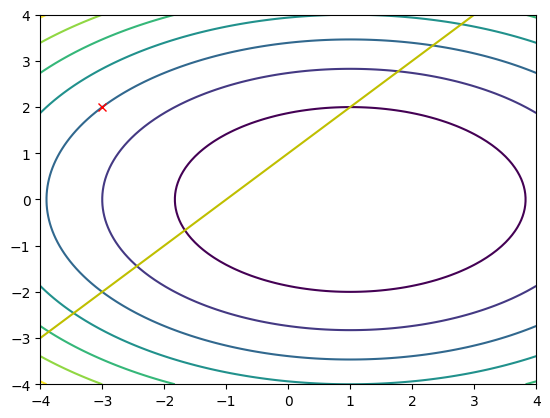

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe1beec2c88>

In [21]:
xguess = [-3; 2]
λguess = [0.0]
ρ = 1.0
plot_landscape()
plot(xguess[1], xguess[2], "rx")

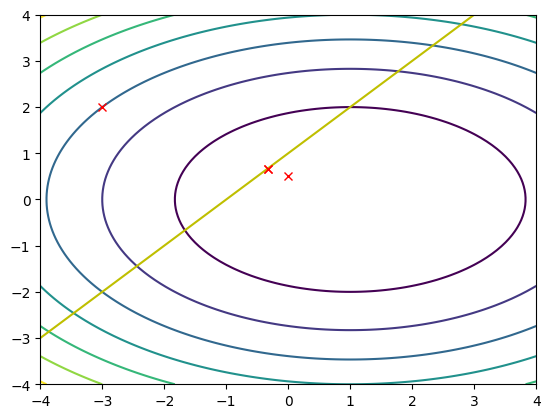

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe1bed90320>

In [24]:
# perform newton's method
xnew = newton_solve(xguess[:,end],λguess[end],ρ)
# update λ for the augmented lagrangian
λnew = max.(0,λguess[end]+ρ*c(xnew))
xguess = [xguess xnew]
λguess = [λguess λnew]
# update the rho penalty scalar
ρ = 10*ρ
plot_landscape()
plot(xguess[1,:], xguess[2,:], "rx")